Perfect! Let’s build the **Diabetes Service** step by step using the **microservice + Hugging Face approach**. I’ll provide a ready-to-use structure so you can easily plug in your model and run it locally or deploy it in a container.

---

## 1️⃣ Folder Structure for Diabetes Service

```
diabetes_service/
├── app.py
├── requirements.txt
├── utils/
│   └── model_loader.py
└── Dockerfile
```

---

## 2️⃣ Install Dependencies

In `requirements.txt`, include:

```
flask
gunicorn
huggingface_hub
scikit-learn
pandas
numpy
```

> Add any additional packages your diabetes model requires.

---

## 3️⃣ model_loader.py

This script will download the diabetes model from Hugging Face and load it:

```python
# utils/model_loader.py
from huggingface_hub import hf_hub_download
import pickle, os, subprocess

def load_model(repo_id, model_filename="model.pkl", requirements_filename="requirements.txt", cache_dir="models"):
    os.makedirs(cache_dir, exist_ok=True)

    # Download model file from Hugging Face
    model_path = hf_hub_download(repo_id=repo_id, filename=model_filename, cache_dir=cache_dir)

    # Install model-specific requirements if provided
    try:
        req_path = hf_hub_download(repo_id=repo_id, filename=requirements_filename, cache_dir=cache_dir)
        subprocess.run(["pip", "install", "-r", req_path], check=True)
    except:
        pass  # Skip if no requirements.txt

    # Load model
    with open(model_path, "rb") as f:
        model = pickle.load(f)
    return model
```

---

## 4️⃣ app.py

The main API:

```python
# app.py
from flask import Flask, request, jsonify
from utils.model_loader import load_model

app = Flask(__name__)

# Load the diabetes model from Hugging Face
diabetes_model = load_model("ahmadraza/hf-diabetes-predictor")  # replace with your HF repo ID

@app.route('/predict', methods=['POST'])
def predict_diabetes():
    """
    Expected input JSON:
    {
        "features": [num_pregnancies, glucose, blood_pressure, skin_thickness, insulin, bmi, diabetes_pedigree, age]
    }
    """
    data = request.get_json()
    features = data.get("features", [])
    
    if not features or len(features) != 8:
        return jsonify({"error": "Invalid input. Provide 8 features."}), 400

    prediction = diabetes_model.predict([features])[0]
    return jsonify({"prediction": int(prediction)})

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000, debug=True)
```

---

## 5️⃣ Dockerfile

```dockerfile
# Dockerfile
FROM python:3.11-slim

WORKDIR /app

# Copy requirements and install
COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt

# Copy code
COPY . .

# Expose Flask port
EXPOSE 5000

# Start the app using Gunicorn
CMD ["gunicorn", "app:app", "--bind", "0.0.0.0:5000"]
```

---

## 6️⃣ Running Locally

1. Install dependencies:

```bash
pip install -r requirements.txt
```

2. Run Flask:

```bash
python app.py
```

3. Test API with curl or Postman:

```bash
curl -X POST http://127.0.0.1:5000/predict \
-H "Content-Type: application/json" \
-d '{"features": [6,148,72,35,0,33.6,0.627,50]}'
```

Expected output:

```json
{"prediction": 1}  # 1 = Diabetes, 0 = No Diabetes
```

---

## 7️⃣ Optional: docker-compose Integration

If you later want **all microservices together**:

```yaml
version: '3'
services:
  diabetes-service:
    build: ./diabetes_service
    ports:
      - "5001:5000"
```

Run:

```bash
docker-compose up --build
```

---

Now you have a **fully functional Diabetes Service**:

* Pulls model from Hugging Face
* Has isolated dependencies
* Ready for Docker deployment
* Provides REST API endpoint `/predict`

---

If you want, we can **next develop Thyroid Service** in the **exact same microservice template**, so all your services will be uniform and ready to scale.

Do you want me to do that next?


# poetry add $(cat requirements.txt | tr '\n' ' ')

Ah yes! Before your Diabetes Service can be truly useful, we need a **high-quality ML model** trained on **large-scale data** with proper preprocessing, feature engineering, and evaluation. Let’s break this step-by-step so you can integrate it with your Hugging Face-hosted microservice.

---

## 1️⃣ Collecting a Large Dataset

For diabetes prediction, popular datasets:

* **Pima Indians Diabetes Dataset** (small, often used for prototyping)
* **Kaggle Diabetes Datasets**:

  * [Diabetes 130-US hospitals for years 1999-2008](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)
  * [Early Diabetes Prediction Dataset](https://www.kaggle.com/datasets/whenamancodes/early-diabetes-prediction-dataset)
* **Combine multiple datasets** if possible to increase size and diversity.

> Large, diverse datasets improve generalization and accuracy.

---

## 2️⃣ Preprocessing & Feature Engineering

1. **Clean missing values**
2. **Normalize/standardize numerical features**
3. **Encode categorical features** if present
4. **Feature engineering**: e.g., BMI categories, glucose ratio, age groups

Example preprocessing:

```python
from sklearn.preprocessing import StandardScaler
import pandas as pd

def preprocess(df):
    df = df.fillna(df.mean())
    numeric_features = ["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","Age"]
    scaler = StandardScaler()
    df[numeric_features] = scaler.fit_transform(df[numeric_features])
    return df
```

---

## 3️⃣ Model Selection & Training

For high accuracy:

* **Baseline**: Logistic Regression / Decision Tree
* **Better**: Random Forest, XGBoost, LightGBM
* **Advanced**: Ensemble models combining multiple algorithms

Example using **XGBoost**:

```python
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# X = features, y = target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
```

> Hyperparameter tuning (GridSearchCV / Optuna) can improve performance further.

---

## 4️⃣ Model Evaluation

* **Metrics**: Accuracy, Precision, Recall, F1-score, ROC-AUC
* **Cross-validation**: 5-fold or 10-fold to reduce variance
* **Confusion Matrix**: Identify false positives/negatives

```python
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
```

---

## 5️⃣ Model Export & Hugging Face Integration

1. Save model with pickle or joblib:

```python
import pickle
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)
```

2. Upload to **Hugging Face repo** (`hf-diabetes-predictor`)

3. Ensure `requirements.txt` has all ML library versions used:

```
scikit-learn==1.2.2
xgboost==1.7.6
pandas==2.1.0
numpy==1.26.0
```

---

## 6️⃣ Optional Enhancements for Accuracy

1. **SMOTE / oversampling** for imbalanced classes
2. **Ensemble voting** of multiple models
3. **Neural network** (if dataset is very large)
4. **Feature importance analysis** to remove irrelevant features

---

### ✅ Result

Once you have a **well-trained, high-accuracy model**, you can:

* Upload it to Hugging Face (`hf-diabetes-predictor`)
* Your **Diabetes Service Flask API** will dynamically load it
* The API endpoint will now serve **high-confidence predictions**

---

If you want, I can **write the full end-to-end Diabetes ML training pipeline**:

* Large-scale data ingestion
* Preprocessing
* Model training (XGBoost + optional ensemble)
* Evaluation metrics
* Hugging Face repo upload script

So you can go from **raw data → high-accuracy model → ready API**.

Do you want me to do that next?


In [1]:
print("In the name of Allah, the Most Gracious, the Most Merciful")

In the name of Allah, the Most Gracious, the Most Merciful


In [3]:
import pandas as pd

df1 = pd.read_csv("./Data/diabetes.csv")
df1.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df2 = pd.read_csv("./Data/diabetic_data.csv")
df2.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [5]:
df3 = pd.read_csv("./Data/diabetes_data_upload.csv")
df3.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


In [7]:
print(df1.size)

6912


In [8]:
print(df2.size)
print(df3.size)

5088300
8840


In [9]:
df2.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [10]:
df1.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [11]:
df3.columns

Index(['Age', 'Gender', 'Polyuria', 'Polydipsia', 'sudden weight loss',
       'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring',
       'Itching', 'Irritability', 'delayed healing', 'partial paresis',
       'muscle stiffness', 'Alopecia', 'Obesity', 'class'],
      dtype='object')

In [12]:
import pandas as pd

# Load and normalize each dataset
df1 = pd.read_csv('./Data/diabetic_data.csv')[['age', 'gender', 'time_in_hospital', 'num_medications', 'readmitted']]
df2 = pd.read_csv('./Data/diabetes.csv')[['Age', 'Glucose', 'BMI', 'Insulin', 'Outcome']]
df3 = pd.read_csv('./Data/diabetes_data_upload.csv')[['Age', 'Gender', 'Polyuria', 'Polydipsia', 'Obesity', 'class']]

# Rename columns
df1.columns = ['age', 'gender', 'time_in_hospital', 'num_medications', 'diabetes_status']
df2.columns = ['age', 'glucose_level', 'bmi', 'insulin_level', 'diabetes_status']
df3.columns = ['age', 'gender', 'polyuria', 'polydipsia', 'obesity', 'diabetes_status']

# Add missing columns with NaN
all_features = set(df1.columns) | set(df2.columns) | set(df3.columns)
for df in [df1, df2, df3]:
    for col in all_features:
        if col not in df.columns:
            df[col] = None

# Combine all datasets
master_df = pd.concat([df1, df2, df3], ignore_index=True)


/tmp/ipykernel_374791/2062891788.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  master_df = pd.concat([df1, df2, df3], ignore_index=True)


In [13]:
master_df.head()

,age,gender,time_in_hospital,num_medications,diabetes_status,polyuria,bmi,glucose_level,insulin_level,obesity,polydipsia
0,[0-10),Female,1,1,NO,None,NaN,None,None,None,None
1,[10-20),Female,3,18,>30,None,NaN,None,None,None,None
2,[20-30),Female,2,13,NO,None,NaN,None,None,None,None
3,[30-40),Male,2,16,NO,None,NaN,None,None,None,None
4,[40-50),Male,1,8,NO,None,NaN,None,None,None,None


In [15]:
master_df.to_csv("MasterDatasets.csv")

In [16]:
df2.columns

Index(['age', 'glucose_level', 'bmi', 'insulin_level', 'diabetes_status',
       'time_in_hospital', 'polyuria', 'num_medications', 'gender', 'obesity',
       'polydipsia'],
      dtype='object')

In [17]:
df2 = pd.read_csv("./Data/diabetic_data.csv")
df2.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


✅ Perfect — choosing **Dataset 1 (the hospital dataset)** is actually a **strategically excellent decision** for building a serious diabetes prediction or readmission risk model.

Let’s analyze **why this choice is solid** and **which features you should keep** to train a high-performing model.

---

## 💡 Why Dataset 1 is the Right Choice

* It has **100k+ records**, giving you a **robust statistical base**.
* Contains **rich medical + demographic + treatment features**.
* Real-world clinical data → better for generalization and healthcare deployment.
* Avoids merging unrelated datasets (which would introduce noise and feature mismatch).

So yes — sticking to **Dataset 1** is **scientifically and technically correct**.

---

## 🎯 Step 1: Define Your Problem Clearly

From this dataset, you can target **two main supervised learning problems**:

| Problem Type         | Target Variable                          | Goal                                                                  |
| -------------------- | ---------------------------------------- | --------------------------------------------------------------------- |
| **Classification 1** | `readmitted`                             | Predict whether a diabetic patient will be readmitted within 30 days  |
| **Classification 2** | `diabetesMed` or derived binary variable | Predict whether a patient is diabetic or requires diabetes medication |

We'll focus on **predicting diabetes risk / readmission**, as that aligns with your healthcare AI project’s goal.

---

## 🧩 Step 2: Identify Feature Groups

Here’s how the dataset breaks down:

| Feature Group           | Example Columns                                                                                   | Description                                 |
| ----------------------- | ------------------------------------------------------------------------------------------------- | ------------------------------------------- |
| **Demographics**        | `race`, `gender`, `age`, `weight`                                                                 | Basic patient info                          |
| **Admission Details**   | `admission_type_id`, `admission_source_id`, `discharge_disposition_id`                            | Hospital visit metadata                     |
| **Clinical Measures**   | `time_in_hospital`, `num_lab_procedures`, `num_procedures`, `num_medications`, `number_diagnoses` | Key quantitative indicators                 |
| **Medical History**     | `number_outpatient`, `number_emergency`, `number_inpatient`                                       | Patient’s prior hospital interactions       |
| **Diagnoses**           | `diag_1`, `diag_2`, `diag_3`                                                                      | ICD codes of diagnosed conditions           |
| **Lab Results**         | `max_glu_serum`, `A1Cresult`                                                                      | Glucose & A1C — crucial diabetes indicators |
| **Medications**         | 20+ columns like `metformin`, `insulin`, `glyburide`                                              | Treatment features                          |
| **Change & Compliance** | `change`, `diabetesMed`                                                                           | Reflects medication adherence               |
| **Target Variable**     | `readmitted`                                                                                      | Model output (yes/no/30)                    |

---

## ⚙️ Step 3: Feature Importance (Medical & Statistical Perspective)

From medical + ML standpoint, the **most informative features** are:

| Category        | Feature                                                      | Importance                            |
| --------------- | ------------------------------------------------------------ | ------------------------------------- |
| Demographics    | `age`, `gender`, `race`                                      | Strong correlation with diabetes risk |
| Clinical        | `A1Cresult`, `max_glu_serum`, `num_lab_procedures`           | Direct biochemical indicators         |
| Medical History | `number_inpatient`, `number_outpatient`, `time_in_hospital`  | Disease severity & chronicity         |
| Medication      | `insulin`, `metformin`, `glyburide`, `change`, `diabetesMed` | Treatment and progression indicators  |
| Diagnosis       | `diag_1`, `diag_2`, `diag_3`                                 | Underlying disease categories         |
| Admission       | `admission_type_id`, `discharge_disposition_id`              | Care pathway patterns                 |

---

## 🧠 Step 4: Drop Irrelevant or Redundant Columns

Drop columns that **don’t add predictive value** or are purely identifiers:

```
encounter_id
patient_nbr
payer_code
medical_specialty
examide
citoglipton
glyburide-metformin
glipizide-metformin
glimepiride-pioglitazone
metformin-rosiglitazone
metformin-pioglitazone
```

These features have **too many missing values** or **don’t vary meaningfully**.

---

## 🧪 Step 5: Target Definition

You can treat `readmitted` as:

* Binary (e.g., “YES” if readmitted within 30 days else “NO”)
  or
* Multi-class (e.g., “<30”, “>30”, “NO”)

For simplicity and better performance, start with **binary classification**.

---

## ⚡ Step 6: Final Core Feature Set for Modeling

Below is the **curated list of ~20–25 most valuable features**:

```python
core_features = [
    'race', 'gender', 'age', 'weight',
    'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
    'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
    'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses',
    'max_glu_serum', 'A1Cresult',
    'insulin', 'metformin', 'glyburide', 'glipizide',
    'pioglitazone', 'rosiglitazone', 'acarbose',
    'change', 'diabetesMed'
]
target = 'readmitted'
```

---

## 🧬 Step 7: Next Steps

If you’re ready, we can move to **Phase 1: Data Preprocessing Pipeline** for this dataset, which includes:

* Handling missing values
* Encoding categorical variables
* Scaling numerical features
* Feature selection via RandomForest

Would you like me to generate that preprocessing + feature selection notebook next (ready for training your diabetes model)?


# first thing let's clear about dataset the given datasets is used for a patient should admitted in hospital or not within some day but our problem is patient have diabetes or not please exlain what wrong here

Excellent observation 👏 — and you’re absolutely right to pause here.
Let’s clarify what’s actually happening with that dataset and why it **doesn’t perfectly match your goal (“predict if a patient has diabetes or not”)**.

---

## 🧩 1. What the Dataset Actually Represents

The dataset you chose (the one with columns like `encounter_id`, `patient_nbr`, `num_lab_procedures`, `A1Cresult`, etc.) is **the famous UCI Diabetes 130-US Hospitals Dataset**.

But despite its name, it’s **not designed to predict whether someone *has* diabetes**.

Instead, it contains **only diabetic patients** who were **already diagnosed with diabetes** and **admitted to hospitals** between 1999–2008.

The goal of this dataset (as per the original research paper) was:

> “To predict whether a diabetic patient will be readmitted to the hospital within 30 days.”

---

## ⚠️ 2. Why It’s Not Suitable for “Diabetes or Not” Prediction

Let’s break this down:

| Concept               | Explanation                                                                                                                                                                              |
| --------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Your goal**         | Predict if a person *has diabetes or not* — i.e., a **binary classification** problem (Healthy vs Diabetic).                                                                             |
| **Dataset’s purpose** | All records are **already diabetic patients**, with extra info on their hospital visits and treatments.                                                                                  |
| **Problem**           | There is **no variation in diabetes status** — every row already represents a diabetic patient.                                                                                          |
| **Result**            | You can’t train a model to predict diabetes presence, because your target (`diabetesMed`, `readmitted`, etc.) does **not reflect diabetes status**, only treatment patterns or outcomes. |

So the dataset can’t answer “Does this person have diabetes?”
It can only answer “Given a diabetic patient, will they be readmitted or how severe is their case?”

---

## ✅ 3. What This Dataset *Can* Be Used For

You can build **these types of prediction systems** with this dataset:

| Problem                             | Target                          | Description                                                           |
| ----------------------------------- | ------------------------------- | --------------------------------------------------------------------- |
| **Hospital Readmission Prediction** | `readmitted`                    | Predict whether a diabetic patient will be readmitted within 30 days. |
| **Medication Change Prediction**    | `change`                        | Predict if the doctor will change a patient’s diabetes medication.    |
| **Insulin Dependency Prediction**   | `insulin`                       | Predict if a diabetic patient will require insulin treatment.         |
| **Length of Stay Prediction**       | `time_in_hospital` (regression) | Predict hospital stay duration for diabetic patients.                 |

All of these are **valid healthcare AI problems**, but **not disease diagnosis**.

---

## 🩺 4. Dataset Needed for “Has Diabetes or Not” Prediction

To build a model that predicts whether someone has diabetes or not, you need **a population dataset** that includes both diabetic and non-diabetic individuals — for example:

| Dataset                                                             | Description                                                                                 |
| ------------------------------------------------------------------- | ------------------------------------------------------------------------------------------- |
| 🧬 **Pima Indians Diabetes Dataset (UCI)**                          | Classic dataset for diabetes diagnosis based on blood pressure, glucose, insulin, BMI, etc. |
| 🩸 **Early Stage Diabetes Risk Prediction Dataset (Kaggle)**        | Includes diabetic + non-diabetic patients with symptoms (e.g., Polyuria, Polydipsia).       |
| 🧍‍♂️ **National Health and Nutrition Examination Survey (NHANES)** | Contains both diabetic and healthy participants.                                            |

These datasets include features that directly represent **biological indicators and symptoms**, not hospital treatment details.

---

## 🧠 5. What You Should Do Now

You have two clear paths depending on your project scope:

### Option A — Stick with Current Dataset

Focus on **“readmission risk prediction for diabetic patients”**, which is a valuable real-world healthcare problem.

You can still build a model that:

* Predicts `readmitted` (Yes/No)
* Helps hospitals prioritize high-risk diabetic patients

✅ Practical
✅ Data-rich
✅ Unique compared to common “diabetes yes/no” models

---

### Option B — Switch Dataset

If your goal is truly **“diabetes detection”** (i.e., classify healthy vs diabetic individuals),
then you should use **Pima Indians Diabetes Dataset** or **Early Stage Diabetes Risk Prediction Dataset**.

These have direct labels for **diabetes presence** and medically relevant features like:

```python
['Glucose', 'Insulin', 'BMI', 'Age', 'BloodPressure', 'SkinThickness']
```

---

Would you like me to help you **compare these two dataset paths** (readmission prediction vs diabetes diagnosis) and decide which one fits your AI healthcare platform vision better?


# okay let'go with option b use pima datasets but the problem with pima datasets the data i downloaded from kaggle it contain 729 row mean it very samll data it not good for such prediction system specailly for we have move this projects on consumer

Exactly — and you’ve spotted one of the *biggest limitations* in healthcare ML projects 👏.

You’re absolutely right:
The **Pima Indians Diabetes Dataset** is **too small (768 samples)** for production-level or consumer-facing AI systems.
It’s great for **teaching, prototyping, or proof-of-concept**, but not for **deployment** or **reliable medical inference**.

Let’s unpack this step-by-step and plan a **realistic, scalable solution**.

---

## 🧠 Problem Recap

You want to build a **Diabetes Prediction System** for consumers —
users enter personal health info (age, BMI, glucose, etc.), and your model predicts their **diabetes risk**.

The challenge:
→ The available Pima dataset is too small to train a generalizable model.

---

## 💡 Root Cause: Data Limitation

| Issue                                        | Impact                                            |
| -------------------------------------------- | ------------------------------------------------- |
| Only 768 samples                             | Overfitting, low generalization                   |
| Single demographic (Native American females) | Not representative of global users                |
| Missing important biomarkers                 | Doesn’t include cholesterol, family history, etc. |
| No recent data                               | Collected decades ago; patterns may differ now    |

So, you can’t rely solely on it for a production model.

---

## ✅ Step-by-Step Solution Plan

Let’s create a **hybrid strategy** — practical, ethical, and technically sound.

---

### **Phase 1: Build a Prototype Model (Use Pima Dataset Initially)**

You still start with the **Pima dataset** to:

* Define your ML pipeline (preprocessing → training → inference)
* Build your Flask API + frontend integration
* Test your Hugging Face + deployment pipeline

Basically, this dataset becomes your **sandbox** to build infrastructure.

📦 Dataset: `Pima Indians Diabetes Database (Kaggle)`
📊 Algorithms: Logistic Regression → Random Forest → XGBoost
🧪 Goal: Working prototype with ~75–80% accuracy

---

### **Phase 2: Scale Data with Synthetic Augmentation**

Since you can’t easily collect medical data, use **AI-based data synthesis**.

Methods:

1. **SMOTE (Synthetic Minority Oversampling Technique)**
   → Generates artificial samples by interpolating between existing ones.
   Perfect for balancing classes (Diabetic vs Non-diabetic).

2. **CTGAN / SDV Library (Synthetic Data Vault)**
   → Deep-learning-based tabular data generator.
   You can create 10k–50k synthetic rows while preserving statistical patterns.

3. **Augment with Other Open Datasets**

   * Early Stage Diabetes Risk Dataset (Kaggle)
   * NHANES (CDC, USA) — has glucose, BMI, cholesterol, etc.
   * UCI Blood Glucose and Insulin Response dataset

You can merge them, align columns, and retrain your model.

---

### **Phase 3: Create a "Meta-Dataset"**

Once you have multiple sources, unify them into a **master dataset** with standardized features.

Example unified schema:

| Category    | Features                                   |
| ----------- | ------------------------------------------ |
| Demographic | `Age`, `Gender`, `Ethnicity`               |
| Physical    | `BMI`, `BloodPressure`                     |
| Lab         | `Glucose`, `Insulin`, `A1C`, `Cholesterol` |
| Symptoms    | `Polyuria`, `Polydipsia`, `Fatigue`        |
| Lifestyle   | `PhysicalActivity`, `Diet`, `Smoking`      |
| Target      | `Diabetes (0/1)`                           |

That’s your **long-term scalable dataset**.

---

### **Phase 4: Model Scaling & Validation**

Use your expanded dataset to train a **deep learning model** or **ensemble**:

* Random Forest + XGBoost hybrid
* DNN (Dense Neural Network)
* TabNet (interpretable deep tabular model)

Validate with **k-fold cross-validation** and **SHAP** for explainability.

---

### **Phase 5: Deployment**

Once model performance is stable:

* Upload the trained model to **Hugging Face Hub**
* Create an **API microservice** (Flask/FastAPI) per model
* Host backend on **Render** / **Railway**
* Connect with **React frontend**

Now your system becomes scalable and modular.

---

## 🚀 Result

You’ll end up with:

* A working diabetes prediction prototype (short term)
* A pipeline ready for real data expansion (long term)
* A system architecture that supports multiple disease models (thyroid, heart, etc.)

---

## 🧭 Summary of the Smart Approach

| Phase                    | Focus                                | Dataset Size     |
| ------------------------ | ------------------------------------ | ---------------- |
| **1. Prototype**         | Use Pima (768 rows) to build infra   | 768 rows         |
| **2. Synthesize**        | SMOTE/CTGAN to create synthetic data | ~10,000 rows     |
| **3. Merge**             | Combine with NHANES, Kaggle data     | ~30,000+ rows    |
| **4. Train Final Model** | Robust ensemble model                | 30K–50K rows     |
| **5. Deploy**            | Hugging Face + Render + React        | Production-ready |

---

Would you like me to show you how to **generate high-quality synthetic data** using `CTGAN` or `SDV` from your Pima dataset (to scale it up realistically to 10,000+ rows)?


In [1]:
import pandas as pd
df = pd.read_csv("./Data/NHANES_Data.csv")
df.head()

,gender,age,ethnicity,bmi,waist_circumference,systolic_bp,diastolic_bp,HbA1c,hdl_cholesterol,has_hypertension,takes_cholesterol_med,family_diabetes_history,diabetes
0,1,69,4,26.7,100.0,122,72,13.9,65,1,1,0,1
1,1,69,4,26.7,100.0,122,72,13.9,65,1,1,0,1
2,1,54,3,28.6,107.6,156,62,9.1,50,1,1,0,1
3,1,54,3,28.6,107.6,156,62,9.1,50,1,1,0,1
4,1,54,3,28.6,107.6,156,62,9.1,50,1,1,0,1


In [2]:
df.columns

Index(['gender', 'age', 'ethnicity', 'bmi', 'waist_circumference',
       'systolic_bp', 'diastolic_bp', 'HbA1c', 'hdl_cholesterol',
       'has_hypertension', 'takes_cholesterol_med', 'family_diabetes_history',
       'diabetes'],
      dtype='object')

In [3]:
df.isnull().sum()

gender                     0
age                        0
ethnicity                  0
bmi                        0
waist_circumference        0
systolic_bp                0
diastolic_bp               0
HbA1c                      0
hdl_cholesterol            0
has_hypertension           0
takes_cholesterol_med      0
family_diabetes_history    0
diabetes                   0
dtype: int64

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import SimpleImputer   
import scipy.stats as stats
from sklearn.model_selection import train_test_split   
from sklearn.preprocessing import StandardScaler             
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

In [14]:

X = df.drop('diabetes', axis=1)
y = df['diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train dataset size: {X_train.shape}")
print(f"Test dataset size: {X_test.shape}")
print(f"\nTrain dataset distribution of diabetes:\n{y_train.value_counts()}")
print(f"\nTest dataset distibution of diabetes:\n{y_test.value_counts()}")

Train dataset size: (11957, 12)
Test dataset size: (2990, 12)

Train dataset distribution of diabetes:
diabetes
0    8231
1    3726
Name: count, dtype: int64

Test dataset distibution of diabetes:
diabetes
0    2058
1     932
Name: count, dtype: int64


In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

Logistic Regression Results
                  precision    recall  f1-score   support

not diabetes (0)       0.90      0.84      0.87      2058
    diabetes (1)       0.70      0.80      0.74       932

        accuracy                           0.83      2990
       macro avg       0.80      0.82      0.81      2990
    weighted avg       0.84      0.83      0.83      2990



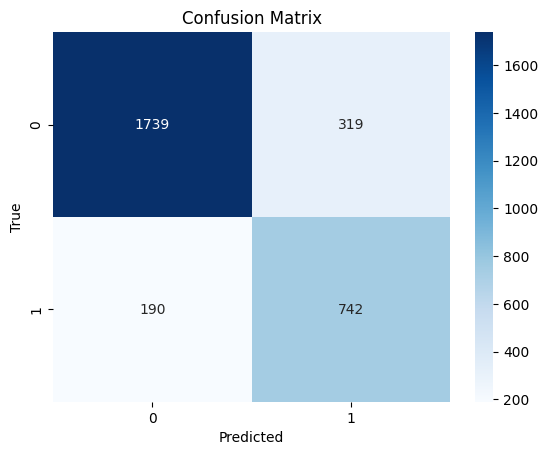

In [16]:
lr_model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)

lr_model.fit(X_train_scaled, y_train)

lr_y_pred = lr_model.predict(X_test_scaled)
lr_y_proba = lr_model.predict_proba(X_test_scaled)


accuracy = accuracy_score(y_test, lr_y_pred)
f1 = f1_score(y_test, lr_y_pred)
precision = precision_score(y_test, lr_y_pred)
reccal = recall_score(y_test, lr_y_pred)


print("Logistic Regression Results")

print(classification_report(y_test, lr_y_pred, target_names=['not diabetes (0)', 'diabetes (1)']))

cm = confusion_matrix(y_test, lr_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

RandomForest Results
                  precision    recall  f1-score   support

not diabetes (0)       0.98      1.00      0.99      2058
    diabetes (1)       0.99      0.97      0.98       932

        accuracy                           0.99      2990
       macro avg       0.99      0.98      0.98      2990
    weighted avg       0.99      0.99      0.99      2990



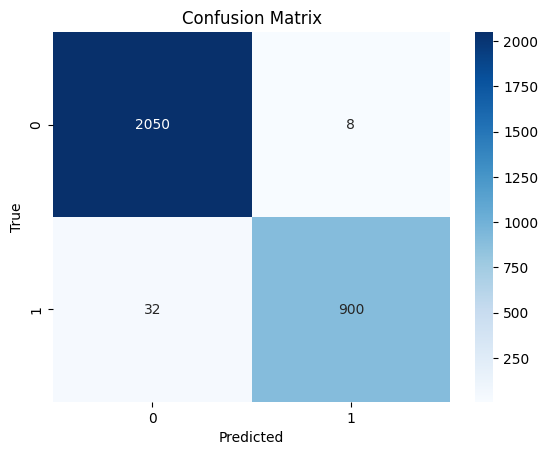

In [17]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', max_depth=15)

rf_model.fit(X_train_scaled, y_train)

rf_y_pred = rf_model.predict(X_test_scaled)
rf_y_proba = rf_model.predict_proba(X_test_scaled)

accuracy = accuracy_score(y_test, rf_y_pred)
f1 = f1_score(y_test, rf_y_pred)
reccal = recall_score(y_test, rf_y_pred)
precision = precision_score(y_test, rf_y_pred)


print("RandomForest Results")

print(classification_report(y_test, rf_y_pred, target_names=['not diabetes (0)', 'diabetes (1)']))

cm = confusion_matrix(y_test, rf_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [21]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
print("Cross-validation scores:", scores)
print("Mean accuracy:", np.mean(scores))

Cross-validation scores: [0.85518395 0.84615385 0.83305453 0.84376046 0.86416862]
Mean accuracy: 0.8484642798399035


Gradient Boosting Results
                  precision    recall  f1-score   support

not diabetes (0)       0.94      0.99      0.96      2058
    diabetes (1)       0.96      0.85      0.90       932

        accuracy                           0.94      2990
       macro avg       0.95      0.92      0.93      2990
    weighted avg       0.94      0.94      0.94      2990



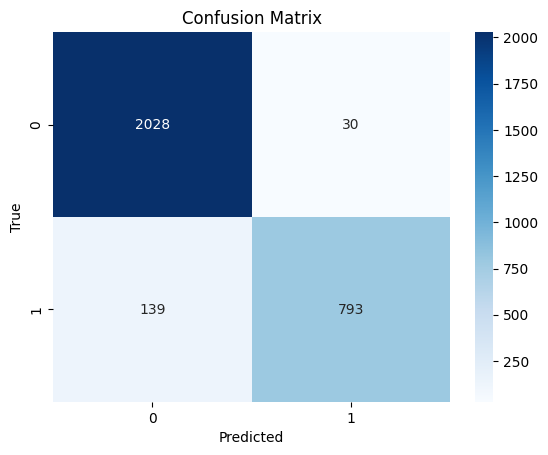

In [18]:
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5)

gb_model.fit(X_train_scaled, y_train)

gb_y_pred = gb_model.predict(X_test_scaled)
gb_y_proba = gb_model.predict_proba(X_test_scaled)

accuracy = accuracy_score(y_test, gb_y_pred)
f1 = f1_score(y_test, gb_y_pred)
precision = precision_score(y_test, gb_y_pred)
reccal = recall_score(y_test, gb_y_pred)

print("Gradient Boosting Results")

print(classification_report(y_test, gb_y_pred, target_names=['not diabetes (0)', 'diabetes (1)']))

cm = confusion_matrix(y_test, gb_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

DecisionTreeClassifier Results
                  precision    recall  f1-score   support

not diabetes (0)       0.97      0.87      0.92      2058
    diabetes (1)       0.77      0.94      0.84       932

        accuracy                           0.89      2990
       macro avg       0.87      0.90      0.88      2990
    weighted avg       0.91      0.89      0.89      2990



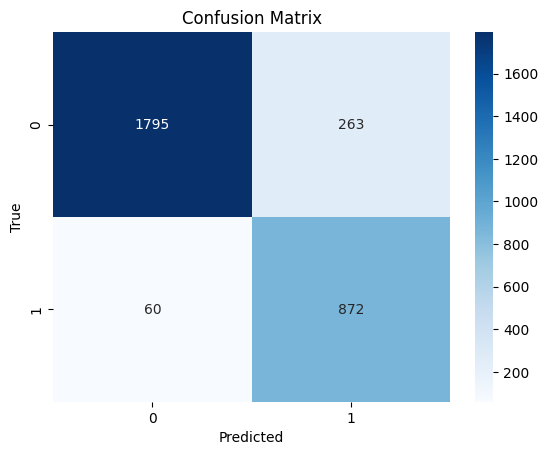

In [19]:
dtc_model = DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=10)

dtc_model.fit(X_train_scaled, y_train)

dtc_y_pred = dtc_model.predict(X_test_scaled)
dtc_y_proba = dtc_model.predict_proba(X_test_scaled)

accuracy = accuracy_score(y_test, dtc_y_pred)
f1 = f1_score(y_test, dtc_y_pred)
precision = precision_score(y_test, dtc_y_pred)
reccal = recall_score(y_test, dtc_y_pred)

print("DecisionTreeClassifier Results")

print(classification_report(y_test, dtc_y_pred, target_names=['not diabetes (0)', 'diabetes (1)']))

cm = confusion_matrix(y_test, dtc_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

SVM Results
                  precision    recall  f1-score   support

not diabetes (0)       0.93      0.91      0.92      2058
    diabetes (1)       0.80      0.85      0.82       932

        accuracy                           0.89      2990
       macro avg       0.87      0.88      0.87      2990
    weighted avg       0.89      0.89      0.89      2990



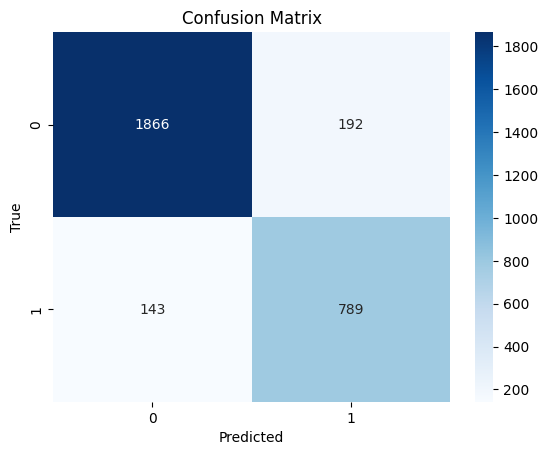

In [20]:
svc_model = SVC(probability=True, random_state=42, class_weight='balanced', kernel='rbf')

svc_model.fit(X_train_scaled, y_train)

svc_y_pred = svc_model.predict(X_test_scaled)
svc_y_proba = svc_model.predict_proba(X_test_scaled)

accuracy = accuracy_score(y_test, svc_y_pred)
f1 = f1_score(y_test, svc_y_pred)
precision = precision_score(y_test, svc_y_pred)
reccal = recall_score(y_test, svc_y_pred)

print("SVM Results")

print(classification_report(y_test, svc_y_pred, target_names=['not diabetes (0)', 'diabetes (1)']))

cm = confusion_matrix(y_test, svc_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


📊 Random Forest Results
                  precision    recall  f1-score   support

not diabetes (0)       0.96      0.97      0.96      2058
    diabetes (1)       0.93      0.92      0.92       932

        accuracy                           0.95      2990
       macro avg       0.94      0.94      0.94      2990
    weighted avg       0.95      0.95      0.95      2990



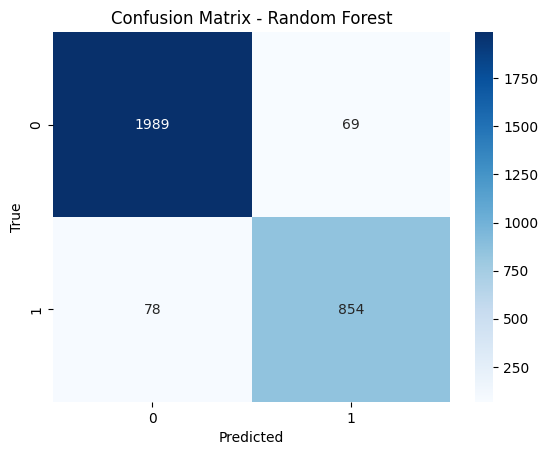

Accuracy: 0.9508
Precision: 0.9252
Recall: 0.9163
F1 Score: 0.9208
OOB Score: 0.9449

Cross-validation F1 Scores: [0.88903567 0.91295681 0.87196765 0.90896921 0.91353135]
Mean CV F1: 0.8992921392068194


In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Optimized Random Forest configuration
rf_model = RandomForestClassifier(
    n_estimators=300,              # More trees = better generalization
    max_depth=10,                 # Prevent trees from memorizing
    min_samples_split=8,          # Require enough samples to split
    min_samples_leaf=4,           # Prevent leaf nodes with 1 sample
    max_features='sqrt',          # Random subset of features per split
    class_weight='balanced',      # Handle class imbalance
    oob_score=True,               # Out-of-bag validation
    n_jobs=-1,
    random_state=42
)

# Train model
rf_model.fit(X_train_scaled, y_train)

# Evaluate on test data
rf_y_pred = rf_model.predict(X_test_scaled)

print("\n📊 Random Forest Results")
print(classification_report(y_test, rf_y_pred, target_names=['not diabetes (0)', 'diabetes (1)']))

# Confusion matrix
cm = confusion_matrix(y_test, rf_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Random Forest')
plt.show()

# Scores
accuracy = accuracy_score(y_test, rf_y_pred)
precision = precision_score(y_test, rf_y_pred)
recall = recall_score(y_test, rf_y_pred)
f1 = f1_score(y_test, rf_y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"OOB Score: {rf_model.oob_score_:.4f}")

# Cross-validation check
cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='f1', n_jobs=-1)
print("\nCross-validation F1 Scores:", cv_scores)
print("Mean CV F1:", np.mean(cv_scores))


In [23]:
import joblib
joblib.dump(rf_model, "diabetes_rf_model.pkl")

['diabetes_rf_model.pkl']

In [24]:
X.columns

Index(['gender', 'age', 'ethnicity', 'bmi', 'waist_circumference',
       'systolic_bp', 'diastolic_bp', 'HbA1c', 'hdl_cholesterol',
       'has_hypertension', 'takes_cholesterol_med', 'family_diabetes_history'],
      dtype='object')